## 3D Example

In [1]:
using Pkg
Pkg.activate(".")

In [46]:
using Revise, DeconvOptim, TestImages, Noise, CUDA, ImageShow, Colors, FFTW, OffsetArrays

FFTW.set_num_threads(4)
CUDA.allowscalar(false);

h_view(args...) = begin
    img = cat(args..., dims=2)
    img ./= maximum(img)
    Gray.(img)
end

h_view (generic function with 1 method)

In [45]:
# load test images
img = Float32.(testimage("simple_3d_ball"))

psf = permutedims(ifftshift(OffsetArrays.no_offset_view(Float32.(testimage("simple_3d_psf")))), (3,1,2))
psf_c = CuArray(psf)

img_b = conv_psf(img, psf, [1,2,3])
img_n = poisson(img_b, 300);

img_n_c = CuArray(img_n);

In [21]:
reg = TV(mode="forward", num_dims=3)

#204 (generic function with 1 method)

In [44]:
@time resG, optim_res = deconvolution(img_n, psf, padding=0.01, loss=Poisson(), regularizer=reg, λ=0.005, iterations=20)

  0.692165 seconds (33.59 k allocations: 890.334 MiB, 6.21% gc time)


(Float32[3.2408907f-6 2.0085336f-6 … 2.0203818f-6 3.2851742f-6; 5.224197f-6 9.540149f-7 … 9.588871f-7 5.316316f-6; … ; 5.2567166f-6 9.406942f-7 … 9.573657f-7 5.3140966f-6; 3.3482077f-6 2.034365f-6 … 2.0732125f-6 3.401027f-6]

Float32[2.0070142f-6 6.2631216f-7 … 6.254797f-7 1.9755155f-6; 9.540139f-7 5.7288855f-7 … 5.707364f-7 9.301303f-7; … ; 9.396439f-7 5.7137777f-7 … 5.7080064f-7 9.362411f-7; 2.0327902f-6 6.265733f-7 … 6.245572f-7 2.1140945f-6]

Float32[9.155538f-8 1.0729938f-7 … 1.0642428f-7 9.478924f-8; 3.18229f-7 1.9013605f-8 … 1.8646661f-8 3.2338255f-7; … ; 3.2129904f-7 1.8581412f-8 … 1.8804828f-8 3.2121238f-7; 8.914809f-8 1.0618037f-7 … 1.0637823f-7 8.1639996f-8]

...

Float32[8.966346f-8 1.073848f-7 … 1.1217327f-7 8.312013f-8; 3.1135835f-7 1.9599716f-8 … 2.103531f-8 3.0533934f-7; … ; 3.0240327f-7 2.1101219f-8 … 2.1691935f-8 3.0996753f-7; 7.62539f-8 1.1250602f-7 … 1.12601874f-7 7.989056f-8]

Float32[2.0283185f-6 6.252173f-7 … 6.259533f-7 2.0137065f-6; 9.666668f-7 5.717516f-7 … 5.

In [23]:
reg_c = TV_cuda(num_dims=3)

#15 (generic function with 1 method)

In [43]:
CUDA.@time resG_c, optim_res_c = deconvolution(img_n_c, psf_c, padding = 0.01, loss=Poisson(), regularizer=reg_c, λ=0.005, iterations=20)

  0.096906 seconds (275.95 k CPU allocations: 8.722 MiB, 6.91% gc time) (2.62 k GPU allocations: 1.902 GiB, 29.23% gc time of which 55.14% spent allocating)


(Float32[3.045015f-6 2.0078994f-6 … 2.0196912f-6 3.0849617f-6; 5.002893f-6 9.660442f-7 … 9.709617f-7 5.089657f-6; … ; 5.03501f-6 9.52816f-7 … 9.694548f-7 5.087226f-6; 3.1433794f-6 2.0331704f-6 … 2.0718971f-6 3.189721f-6]

Float32[2.0064044f-6 5.9198874f-7 … 5.9122414f-7 1.9751637f-6; 9.660439f-7 5.4189445f-7 … 5.3986514f-7 9.421727f-7; … ; 9.5176756f-7 5.404669f-7 … 5.3992744f-7 9.482745f-7; 2.0316158f-6 5.9239756f-7 … 5.903637f-7 2.1116457f-6]

Float32[8.038131f-8 9.907793f-8 … 9.825235f-8 8.339545f-8; 2.947896f-7 1.6601708f-8 … 1.6266824f-8 2.9972222f-7; … ; 2.9772346f-7 1.6207226f-8 … 1.641149f-8 2.97639f-7; 7.817928f-8 9.8015235f-8 … 9.820827f-8 7.124253f-8]

...

Float32[7.862824f-8 9.915883f-8 … 1.0369184f-7 7.255277f-8; 2.8823203f-7 1.7138635f-8 … 1.8455797f-8 2.8247138f-7; … ; 2.7967562f-7 1.8515177f-8 … 1.906087f-8 2.868737f-7; 6.6217716f-8 1.0400511f-7 … 1.0410428f-7 6.959089f-8]

Float32[2.0275204f-6 5.9096436f-7 … 5.9168883f-7 2.0132343f-6; 9.786974f-7 5.408386f-7 … 5.43596

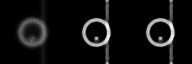

In [25]:
h_view(img_n[32, :, :], resG[32, :, :], Array(resG_c)[32, :, :])

In [35]:
.≈(resG .+ 1, Array(1 .+ resG_c), rtol=1e-2) |> all

true